# Alzheimer's Disease Prediction - Ensemble Learning Approaches

This notebook explores various ensemble learning techniques to potentially improve the model performance for Alzheimer's disease prediction, with a focus on voting classifiers. We'll implement and compare several approaches including:

1. Hard voting classifiers
2. Soft voting classifiers
3. Weighted voting classifiers
4. Stacking ensemble models
5. Combining with dimensionality reduction techniques

The goal is to leverage the strengths of multiple models to achieve better predictive performance for Alzheimer's disease diagnosis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

# Import ensemble models
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier

# Import dimensionality reduction methods for combined analysis
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# For displaying plots inline
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading and Preparing the Data

We'll load the processed data from the previous feature engineering approaches and prepare it for our ensemble models.

In [2]:
# Load the feature-engineered data
# First check which approach performed better in previous notebooks
fe_statistical = pd.read_csv('fe_statistical_approach.csv')
fe_model_based = pd.read_csv('fe_model_based_approach.csv')

# We'll use both approaches and compare results
# Approach 1: Statistical feature engineering
data_statistical = fe_statistical.copy()
X_statistical = data_statistical.drop("Alzheimer's Diagnosis", axis=1)
y = data_statistical["Alzheimer's Diagnosis"]

# Approach 2: Model-based feature engineering
data_model_based = fe_model_based.copy()
X_model_based = data_model_based.drop("Alzheimer's Diagnosis", axis=1)

# Split the data into training and testing sets
X_stat_train, X_stat_test, y_train, y_test = train_test_split(X_statistical, y, test_size=0.2, random_state=42, stratify=y)
X_model_train, X_model_test, y_train_dup, y_test_dup = train_test_split(X_model_based, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler_stat = StandardScaler()
X_stat_train_scaled = scaler_stat.fit_transform(X_stat_train)
X_stat_test_scaled = scaler_stat.transform(X_stat_test)

scaler_model = StandardScaler()
X_model_train_scaled = scaler_model.fit_transform(X_model_train)
X_model_test_scaled = scaler_model.transform(X_model_test)

print(f"Statistical approach features shape: {X_stat_train_scaled.shape}")
print(f"Model-based approach features shape: {X_model_train_scaled.shape}")

Statistical approach features shape: (59426, 23)
Model-based approach features shape: (59426, 19)


## 2. Load Pre-trained Models from Previous Analysis

We'll load the best performing models from our previous analyses to include them in our ensemble models.

In [3]:
# Function to safely load models
def load_model(file_path):
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Warning: Model file {file_path} not found. Creating new instance.")
        return None

# Load pre-trained models if available
lr_model = load_model('logistic_regression_best_model.pkl')
rf_model = load_model('random_forest_best_model.pkl')
gb_model = load_model('gradient_boosting_best_model.pkl')

# Create base model instances if pre-trained models not available
if lr_model is None:
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
if rf_model is None:
    rf_model = RandomForestClassifier(random_state=42)
if gb_model is None:
    gb_model = GradientBoostingClassifier(random_state=42)

# Create additional models for ensembling
svm_model = SVC(probability=True, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# List all models for easy reference
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model
}

## 3. Define Evaluation Framework

We'll create a comprehensive evaluation framework for our ensemble models, including cross-validation and performance metrics.

In [4]:
# Function to evaluate models with cross-validation
def evaluate_model_cv(model, X, y, cv=5):
    # Determine which metrics can be scored
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
    can_score_roc_auc = False
    if hasattr(model, 'predict_proba'):
        can_score_roc_auc = True
    elif hasattr(model, 'decision_function') and not isinstance(model, VotingClassifier) and getattr(model, 'voting', '') != 'hard':
        # decision_function can sometimes be used for roc_auc, but be careful with VotingClassifier(voting='hard')
        # For simplicity, we primarily rely on predict_proba for roc_auc in cross_validate
        # Scikit-learn's cross_validate with roc_auc primarily looks for predict_proba
        pass # Sticking to predict_proba for roc_auc in cross_validate for broader compatibility

    if can_score_roc_auc:
        scoring_metrics.append('roc_auc')
    else:
        print(f"Warning: Model {type(model).__name__} may not support predict_proba. ROC AUC might not be calculated in cross-validation or might result in NaN.")

    cv_results = cross_validate(
        model, X, y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring=scoring_metrics,
        return_train_score=True,
        error_score=np.nan # Set to np.nan to handle errors gracefully if a metric fails for a fold
    )
    
    # Compute mean and std of metrics
    metrics_summary = {}
    # Define all metrics we expect, including roc_auc
    all_possible_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    for metric_name in all_possible_metrics:
        test_metric_key = f'test_{metric_name}'
        if test_metric_key in cv_results and not np.all(np.isnan(cv_results[test_metric_key])):
            metrics_summary[test_metric_key] = {
                'mean': np.nanmean(cv_results[test_metric_key]), # Use nanmean
                'std': np.nanstd(cv_results[test_metric_key])    # Use nanstd
            }
        else:
            # Metric was not scored or all attempts resulted in NaN
            metrics_summary[test_metric_key] = {
                'mean': np.nan,
                'std': np.nan
            }
            if metric_name == 'roc_auc' and not can_score_roc_auc :
                 print(f"Note: ROC AUC for {type(model).__name__} is NaN as predict_proba is not available or suitable.")
    
    return metrics_summary

# Function for detailed model evaluation on test set
def evaluate_model_test(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    y_prob = None
    roc_auc = None
    
    # Check if the model supports probability predictions
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    elif hasattr(model, 'decision_function'):  # For SVM without probability
        # Ensure it's not a hard voting classifier trying to use decision_function inappropriately
        if not (isinstance(model, VotingClassifier) and getattr(model, 'voting', '') == 'hard'):
            try:
                y_scores = model.decision_function(X_test)
                # Ensure y_scores is 1D for roc_auc_score if it's 2D (e.g. SVC with decision_function)
                if y_scores.ndim == 2 and y_scores.shape[1] == 2:
                    y_prob = y_scores[:, 1]
                else:
                    y_prob = y_scores
                roc_auc = roc_auc_score(y_test, y_prob)
            except Exception as e:
                print(f"Warning: Error using decision_function for ROC AUC with {type(model).__name__}: {e}. ROC AUC will be None.")
                roc_auc = None
                y_prob = y_pred # Fallback
        else:
            y_prob = y_pred # Fallback for hard voting
            print(f"Warning: {type(model).__name__} (hard voting) doesn't support probability or decision_function for ROC AUC. ROC AUC will be None.")
            roc_auc = None
    else:
        # For hard voting and other models without probability outputs
        y_prob = y_pred  # Use predictions as y_prob for consistency in return types
        print(f"Warning: {type(model).__name__} doesn't support probability predictions. ROC AUC will be None.")
        roc_auc = None # Explicitly set roc_auc to None
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc  # This will be None for hard voting if not calculable
    }
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return metrics, cm, y_prob

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_prob_dict, model_names):
    plt.figure(figsize=(10, 8))
    for model_name in model_names:
        y_prob = y_prob_dict.get(model_name) # Use .get for safety
        
        # Skip models that don't have valid probability outputs for ROC
        if y_prob is None:
            print(f"Skipping ROC curve for {model_name} - no probability outputs (y_prob is None).")
            continue
        
        # Check if y_prob contains only class labels (e.g., from hard voting)
        # A simple check: if all values are integers (0 or 1 for binary classification)
        # and there are only two unique values, it's likely class labels not probabilities.
        unique_values = np.unique(y_prob)
        if len(unique_values) <= 2 and np.all(np.isin(unique_values, [0, 1])):
             # Attempt to calculate ROC AUC anyway, but it might not be meaningful
             # Or, you could choose to skip plotting for such cases if roc_auc_score would fail or be misleading
            print(f"Warning: y_prob for {model_name} looks like class labels. ROC curve might not be meaningful.")
            # If you want to strictly skip:
            # print(f"Skipping ROC curve for {model_name} - y_prob appears to be class labels, not probabilities.")
            # continue

        try:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.3f})')
        except ValueError as e:
            print(f"Could not plot ROC curve for {model_name}: {e}. y_prob might not be valid probabilities.")
            continue # Skip this model if roc_curve fails
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


## 4. Hard Voting Ensemble

In hard voting, the predicted class label for each test instance is the one that receives the highest number of votes from the base classifiers.

Evaluating Hard Voting Classifier with statistical features:
Note: ROC AUC for VotingClassifier is NaN as predict_proba is not available or suitable.
test_accuracy: 0.7240 (±0.0028)
test_precision: 0.6563 (±0.0051)
test_recall: 0.6985 (±0.0072)
test_f1: 0.6767 (±0.0028)
test_roc_auc: nan (±nan)

Evaluating Hard Voting Classifier with model-based features:
Note: ROC AUC for VotingClassifier is NaN as predict_proba is not available or suitable.
test_accuracy: 0.7246 (±0.0022)
test_precision: 0.6583 (±0.0051)
test_recall: 0.6945 (±0.0099)
test_f1: 0.6758 (±0.0031)
test_roc_auc: nan (±nan)

Test performance with statistical features:
accuracy: 0.7276
precision: 0.6597
recall: 0.7047
f1: 0.6815
roc_auc: None


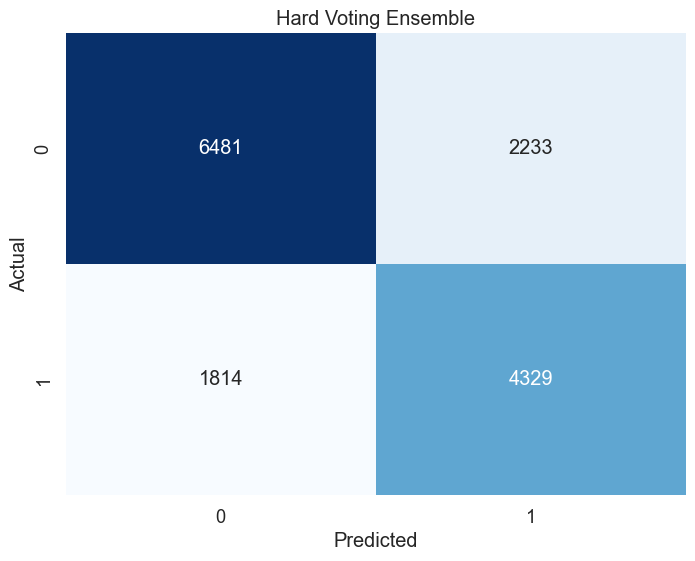

In [5]:
# Create hard voting classifier
hard_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
    ],
    voting='hard'
)

# Evaluate with cross-validation
print("Evaluating Hard Voting Classifier with statistical features:")
hard_voting_cv_stat = evaluate_model_cv(hard_voting_clf, X_stat_train_scaled, y_train)
for metric, values in hard_voting_cv_stat.items():
    print(f"{metric}: {values['mean']:.4f} (±{values['std']:.4f})")

print("\nEvaluating Hard Voting Classifier with model-based features:")
hard_voting_cv_model = evaluate_model_cv(hard_voting_clf, X_model_train_scaled, y_train)
for metric, values in hard_voting_cv_model.items():
    print(f"{metric}: {values['mean']:.4f} (±{values['std']:.4f})")

# Evaluate on test set
print("\nTest performance with statistical features:")
hard_metrics_stat, hard_cm_stat, hard_prob_stat = evaluate_model_test(
    hard_voting_clf, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
)
for metric, value in hard_metrics_stat.items():
    if value is not None:
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")
              

plot_confusion_matrix(cm=hard_cm_stat, title="Hard Voting Ensemble")

## 5. Soft Voting Ensemble

In soft voting, each classifier provides a probability estimate for each class, and these probabilities are averaged to find the final class prediction.

Evaluating Soft Voting Classifier with statistical features:
test_accuracy: 0.7239 (±0.0021)
test_precision: 0.6664 (±0.0043)
test_recall: 0.6657 (±0.0064)
test_f1: 0.6660 (±0.0026)
test_roc_auc: 0.8003 (±0.0023)

Evaluating Soft Voting Classifier with model-based features:
test_accuracy: 0.7253 (±0.0020)
test_precision: 0.6676 (±0.0038)
test_recall: 0.6684 (±0.0066)
test_f1: 0.6679 (±0.0029)
test_roc_auc: 0.8006 (±0.0025)

Test performance with statistical features:
accuracy: 0.7279
precision: 0.6718
recall: 0.6684
f1: 0.6701
roc_auc: 0.8056


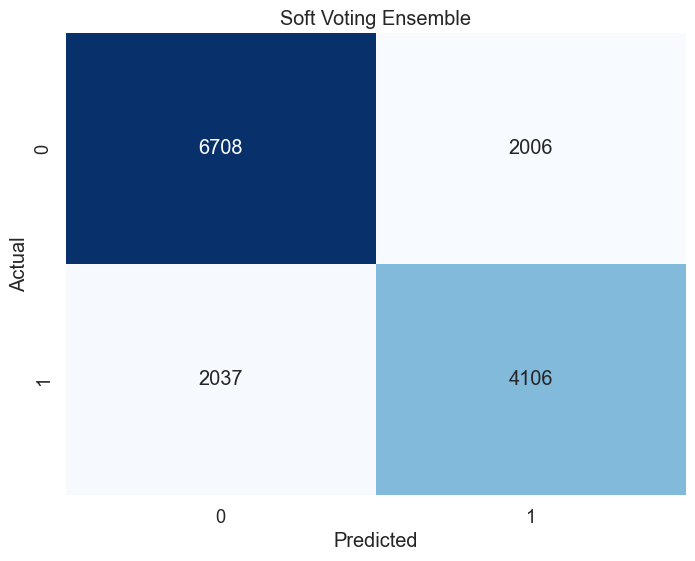

In [6]:
# Create soft voting classifier
# Note: All classifiers need to support predict_proba
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
    ],
    voting='soft'
)

# Evaluate with cross-validation
print("Evaluating Soft Voting Classifier with statistical features:")
soft_voting_cv_stat = evaluate_model_cv(soft_voting_clf, X_stat_train_scaled, y_train)
for metric, values in soft_voting_cv_stat.items():
    print(f"{metric}: {values['mean']:.4f} (±{values['std']:.4f})")

print("\nEvaluating Soft Voting Classifier with model-based features:")
soft_voting_cv_model = evaluate_model_cv(soft_voting_clf, X_model_train_scaled, y_train)
for metric, values in soft_voting_cv_model.items():
    print(f"{metric}: {values['mean']:.4f} (±{values['std']:.4f})")

# Evaluate on test set
print("\nTest performance with statistical features:")
soft_metrics_stat, soft_cm_stat, soft_prob_stat = evaluate_model_test(
    soft_voting_clf, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
)
for metric, value in soft_metrics_stat.items():
    print(f"{metric}: {value:.4f}")

plot_confusion_matrix(cm=soft_cm_stat, title="Soft Voting Ensemble")

## 6. Weighted Voting Ensemble

In weighted voting, we assign different weights to each classifier based on their performance, giving more influence to better-performing models.

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training XGBoost...

Individual model performance:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.717978   0.676998  0.608009  0.640652  0.793697
Random Forest        0.728276   0.646780  0.755331  0.696854  0.805939
Gradient Boosting    0.730228   0.659686  0.717890  0.687558  0.808640
SVM                  0.724238   0.679097  0.631450  0.654407  0.786537
XGBoost              0.716699   0.657955  0.655706  0.656828  0.794853

Evaluating Weighted Voting Classifier:
accuracy: 0.7280
precision: 0.6716
recall: 0.6697
f1: 0.6706
roc_auc: 0.8056


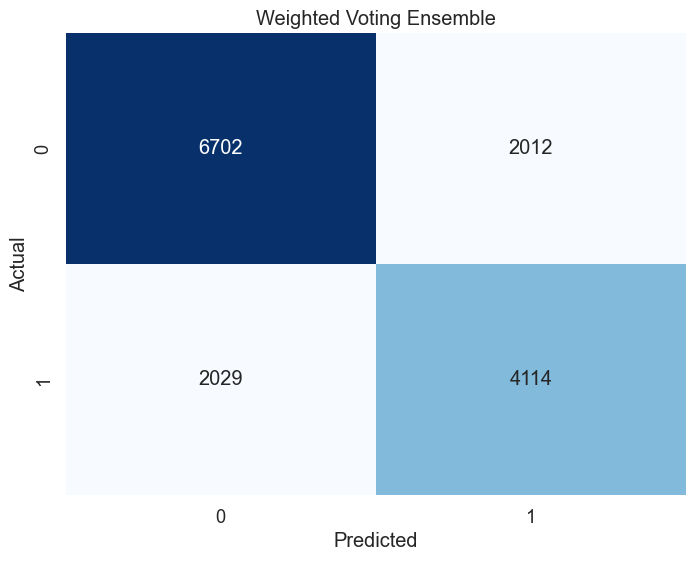

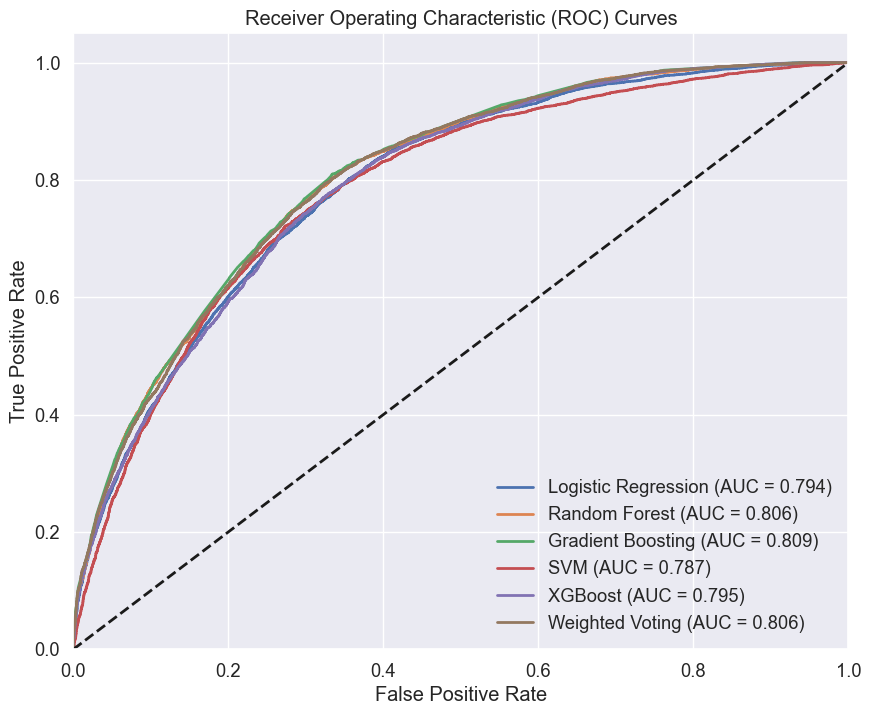

In [7]:
# Train individual models to determine weights
model_metrics = {}
model_probs = {}

for name, model in models.items():
    # Skip CatBoost for weighted voting (to be used later in stacking)
    if name == 'CatBoost':
        continue
        
    print(f"Training {name}...")
    metrics, _, probs = evaluate_model_test(
        model, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
    )
    model_metrics[name] = metrics
    model_probs[name] = probs

# Display performance metrics for each model
metrics_df = pd.DataFrame({
    name: {
        metric: value for metric, value in metrics.items()
    } for name, metrics in model_metrics.items()
})

print("\nIndividual model performance:")
print(metrics_df.T)

# Assign weights based on AUC scores
weights = {name: metrics['roc_auc'] for name, metrics in model_metrics.items()}

# Create weighted voting classifier
weighted_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('gb', gb_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
    ],
    voting='soft',
    weights=[weights['Logistic Regression'], 
             weights['Random Forest'], 
             weights['Gradient Boosting'], 
             weights['SVM'], 
             weights['XGBoost']]
)

# Evaluate weighted voting
print("\nEvaluating Weighted Voting Classifier:")
weighted_metrics, weighted_cm, weighted_prob = evaluate_model_test(
    weighted_voting_clf, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
)
for metric, value in weighted_metrics.items():
    print(f"{metric}: {value:.4f}")

plot_confusion_matrix(cm=weighted_cm, title="Weighted Voting Ensemble")

# Add probabilities for the weighted voting model
model_probs['Weighted Voting'] = weighted_prob

# Plot ROC curves
plot_roc_curve(y_test, model_probs, list(model_probs.keys()))

## 7. Stacking Ensemble Model

Stacking involves training a meta-model that combines the predictions of multiple base models, potentially capturing more complex patterns than simple voting.

Evaluating Stacking Classifier with statistical features:
accuracy: 0.7297
precision: 0.6560
recall: 0.7281
f1: 0.6902
roc_auc: 0.8053


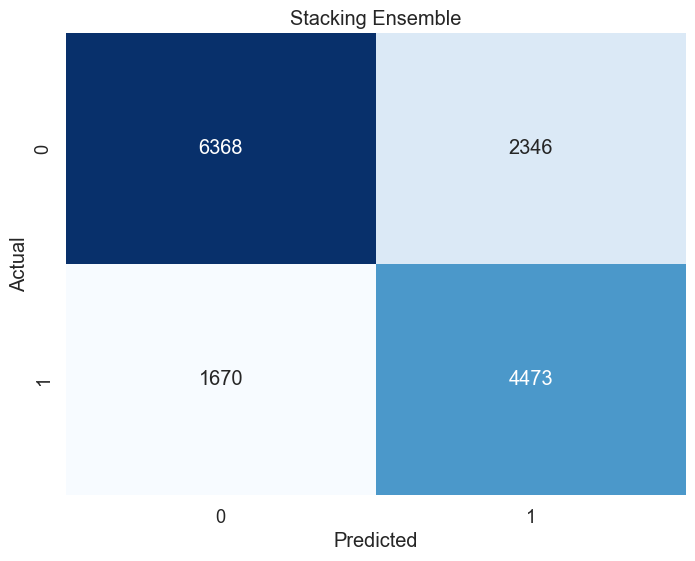


Evaluating Stacking Classifier with model-based features:
accuracy: 0.7307
precision: 0.6563
recall: 0.7321
f1: 0.6921
roc_auc: 0.8060


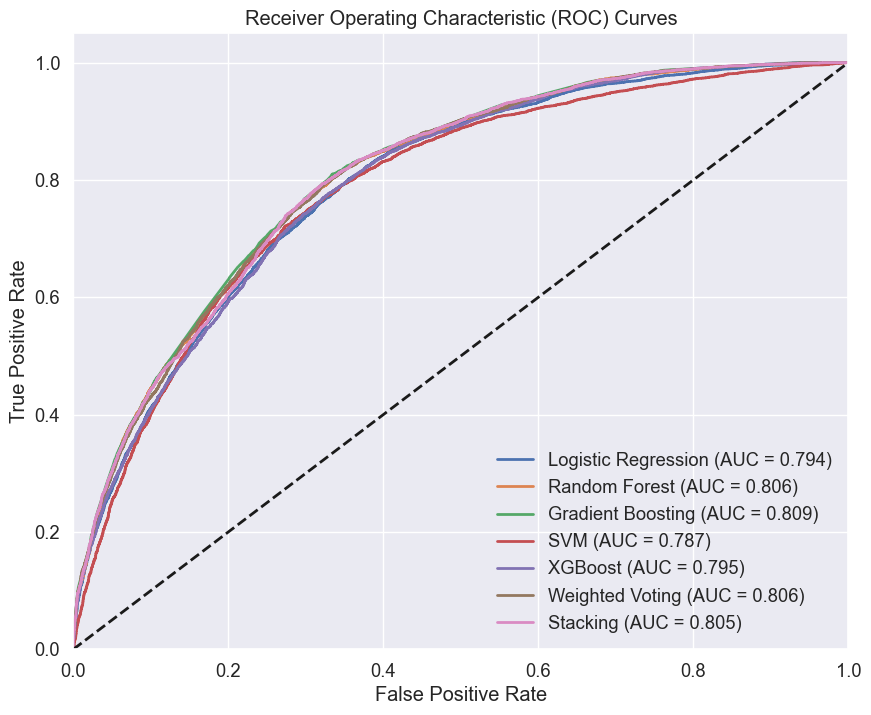

In [8]:
# Create a stacking classifier
# We'll use logistic regression as the final estimator
estimators = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('gb', gb_model),
    ('svm', svm_model),
    ('xgb', xgb_model),
]

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    cv=5,
    stack_method='predict_proba'
)

# Evaluate stacking classifier
print("Evaluating Stacking Classifier with statistical features:")
stack_metrics_stat, stack_cm_stat, stack_prob_stat = evaluate_model_test(
    stack_clf, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
)
for metric, value in stack_metrics_stat.items():
    print(f"{metric}: {value:.4f}")

plot_confusion_matrix(cm=stack_cm_stat, title="Stacking Ensemble")

print("\nEvaluating Stacking Classifier with model-based features:")
stack_metrics_model, stack_cm_model, stack_prob_model = evaluate_model_test(
    stack_clf, X_model_train_scaled, X_model_test_scaled, y_train, y_test
)
for metric, value in stack_metrics_model.items():
    print(f"{metric}: {value:.4f}")

# Add stacking model probabilities
model_probs['Stacking'] = stack_prob_stat

# Plot updated ROC curves with stacking model included
plot_roc_curve(y_test, model_probs, list(model_probs.keys()))

## 8. Combining Dimensionality Reduction with Ensemble Learning

Here we'll explore whether combining dimensionality reduction techniques with our best performing ensemble model can further improve performance.


Evaluating PCA + Ensemble:
accuracy: 0.7213
precision: 0.6524
recall: 0.6975
f1: 0.6742
roc_auc: 0.7976


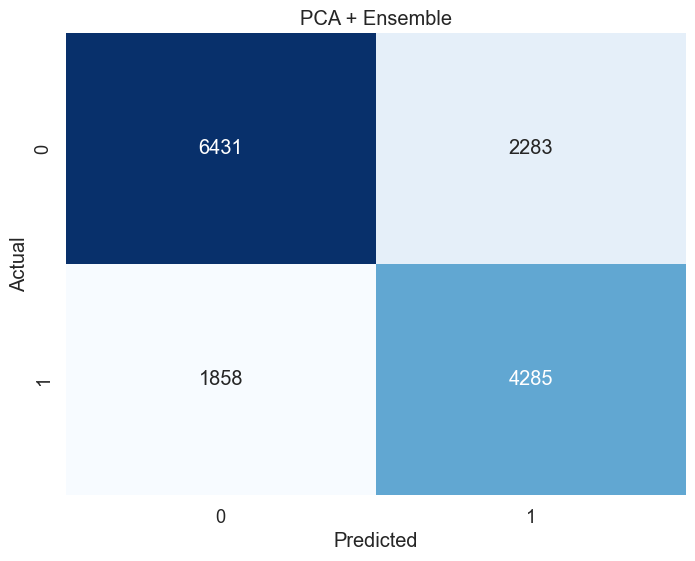


Evaluating LDA + Ensemble:
accuracy: 0.7182
precision: 0.6584
recall: 0.6621
f1: 0.6602
roc_auc: 0.7942


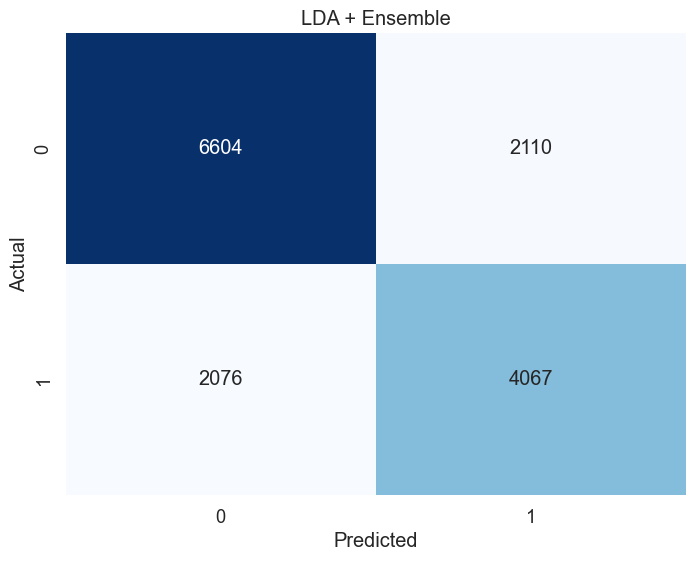


Evaluating SelectKBest + Ensemble:
accuracy: 0.7297
precision: 0.6543
recall: 0.7342
f1: 0.6919
roc_auc: 0.8040


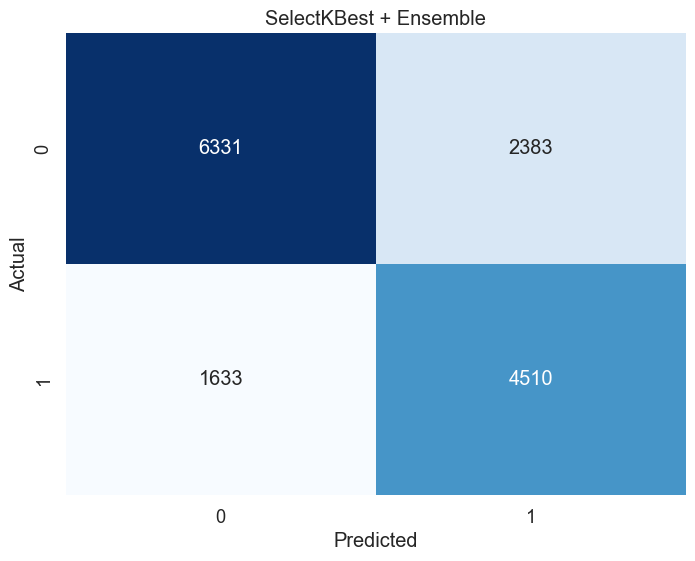


Evaluating Ensemble Only:
accuracy: 0.7297
precision: 0.6560
recall: 0.7281
f1: 0.6902
roc_auc: 0.8053


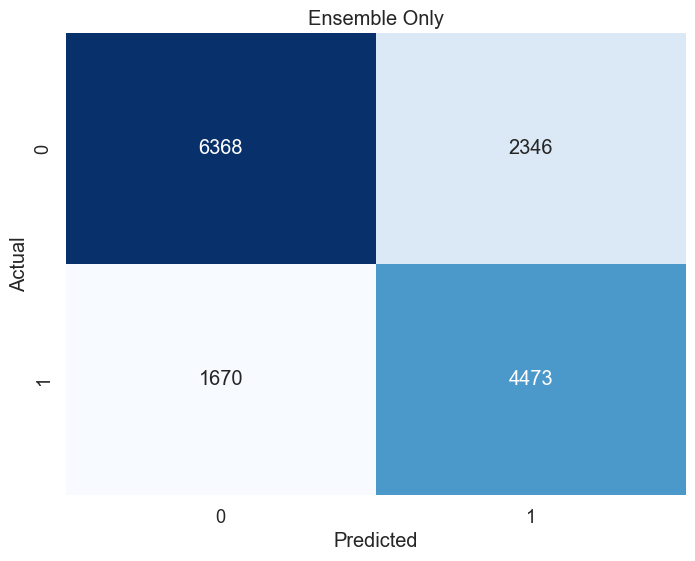


Pipeline performance comparison:
                        accuracy  precision    recall        f1   roc_auc
PCA + Ensemble          0.721276   0.652406  0.697542  0.674219  0.797638
LDA + Ensemble          0.718247   0.658410  0.662054  0.660227  0.794200
SelectKBest + Ensemble  0.729690   0.654287  0.734169  0.691930  0.803976
Ensemble Only           0.729690   0.655961  0.728146  0.690171  0.805301


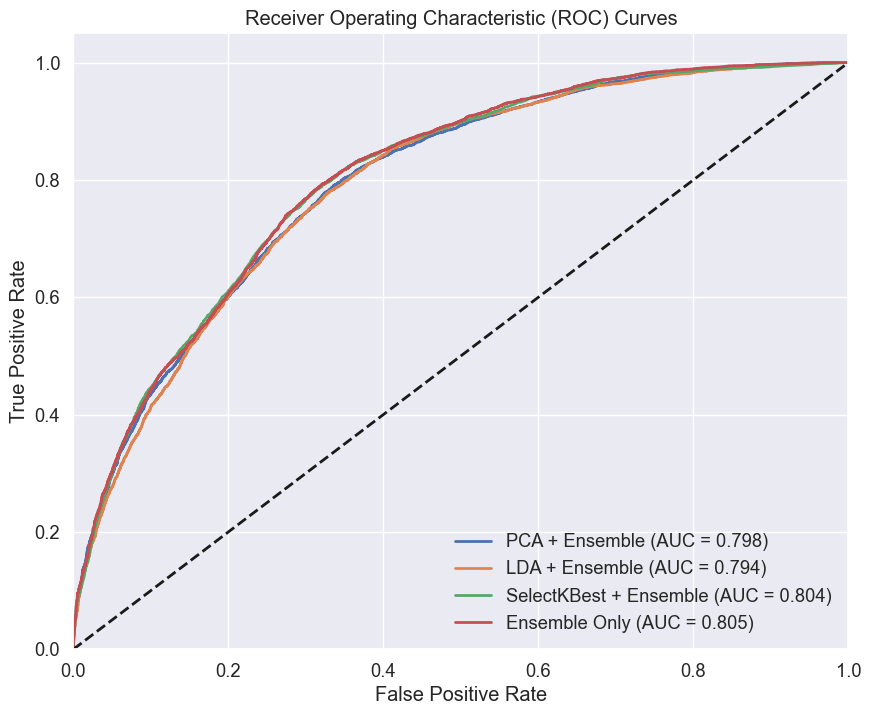

In [9]:
# Create pipelines combining dimensionality reduction with ensemble methods
# We'll use the best performing ensemble method from above

# Determine best ensemble model (let's assume stacking for this example)
best_ensemble_model = stack_clf

# Create pipelines with different dimensionality reduction techniques
pipelines = {
    'PCA + Ensemble': Pipeline([
        ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
        ('ensemble', best_ensemble_model)
    ]),
    'LDA + Ensemble': Pipeline([
        ('lda', LDA(n_components=1)),  # Binary classification -> 1 component
        ('ensemble', best_ensemble_model)
    ]),
    'SelectKBest + Ensemble': Pipeline([
        ('select', SelectKBest(f_classif, k=10)),  # Select top 10 features
        ('ensemble', best_ensemble_model)
    ]),
    'Ensemble Only': best_ensemble_model
}

# Evaluate all pipelines
pipeline_metrics = {}
pipeline_probs = {}

for name, pipeline in pipelines.items():
    print(f"\nEvaluating {name}:")
    metrics, cm, probs = evaluate_model_test(
        pipeline, X_stat_train_scaled, X_stat_test_scaled, y_train, y_test
    )
    pipeline_metrics[name] = metrics
    pipeline_probs[name] = probs
    
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    plot_confusion_matrix(cm=cm, title=name)

# Compare pipeline performance
pipeline_df = pd.DataFrame({
    name: {
        metric: value for metric, value in metrics.items()
    } for name, metrics in pipeline_metrics.items()
})

print("\nPipeline performance comparison:")
print(pipeline_df.T)

# Plot ROC curves for the pipelines
plot_roc_curve(y_test, pipeline_probs, list(pipeline_probs.keys()))

## 9. Comprehensive Model Comparison

Let's compare all the models we've developed, including individual models and ensembles, to identify the best approach.


All model performance metrics:
                        accuracy  precision    recall        f1   roc_auc
Random Forest           0.728276   0.646780  0.755331  0.696854  0.805939
SelectKBest + Ensemble  0.729690   0.654287  0.734169  0.691930  0.803976
Stacking                0.729690   0.655961  0.728146  0.690171  0.805301
Ensemble Only           0.729690   0.655961  0.728146  0.690171  0.805301
Gradient Boosting       0.730228   0.659686  0.717890  0.687558  0.808640
Hard Voting             0.727603   0.659707  0.704705  0.681464       NaN
PCA + Ensemble          0.721276   0.652406  0.697542  0.674219  0.797638
Weighted Voting         0.728007   0.671564  0.669705  0.670633  0.805640
Soft Voting             0.727872   0.671793  0.668403  0.670094  0.805607
LDA + Ensemble          0.718247   0.658410  0.662054  0.660227  0.794200
XGBoost                 0.716699   0.657955  0.655706  0.656828  0.794853
SVM                     0.724238   0.679097  0.631450  0.654407  0.786537
Logist

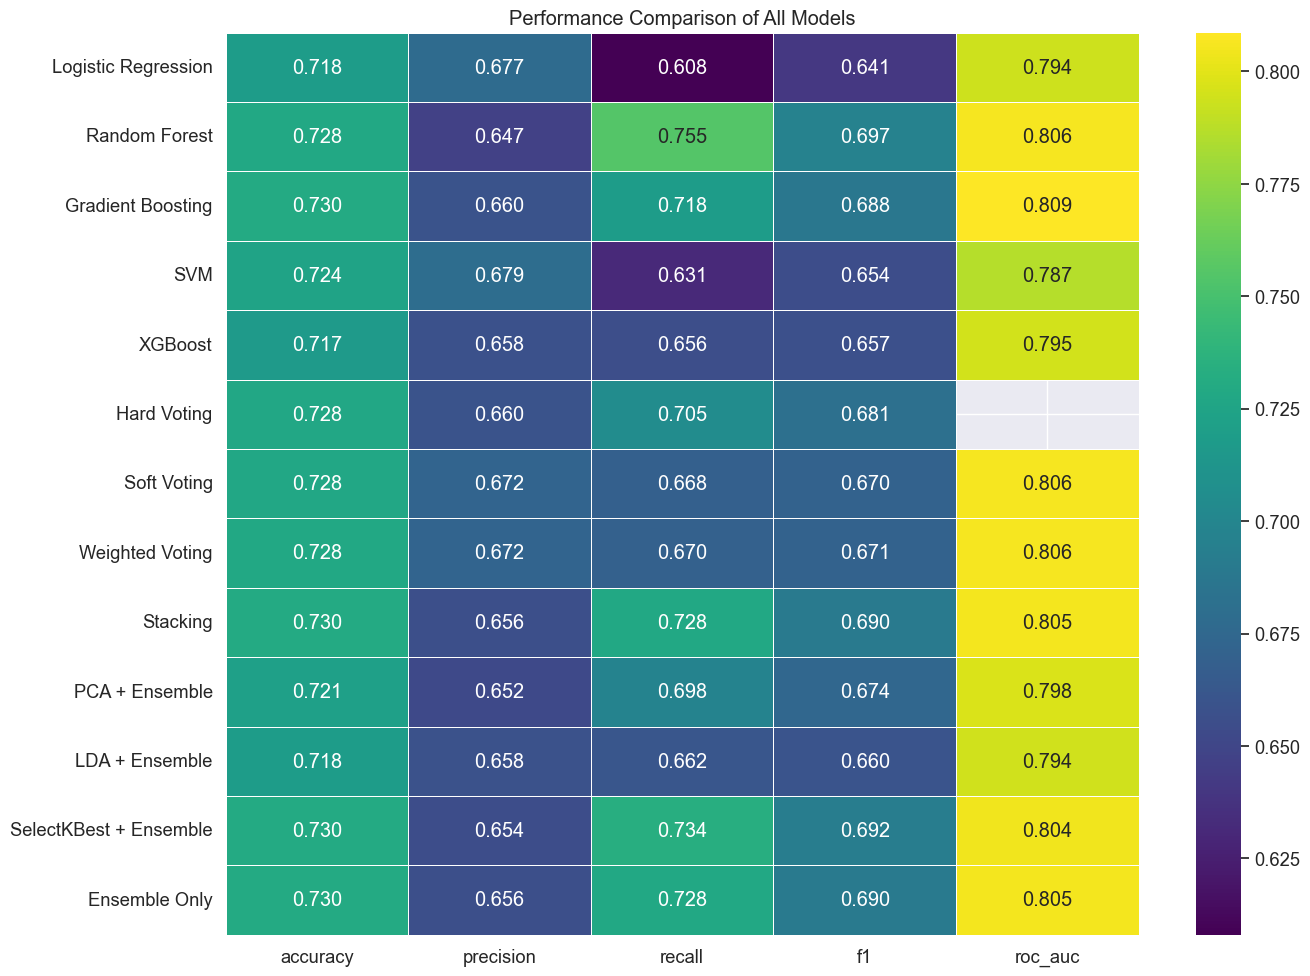

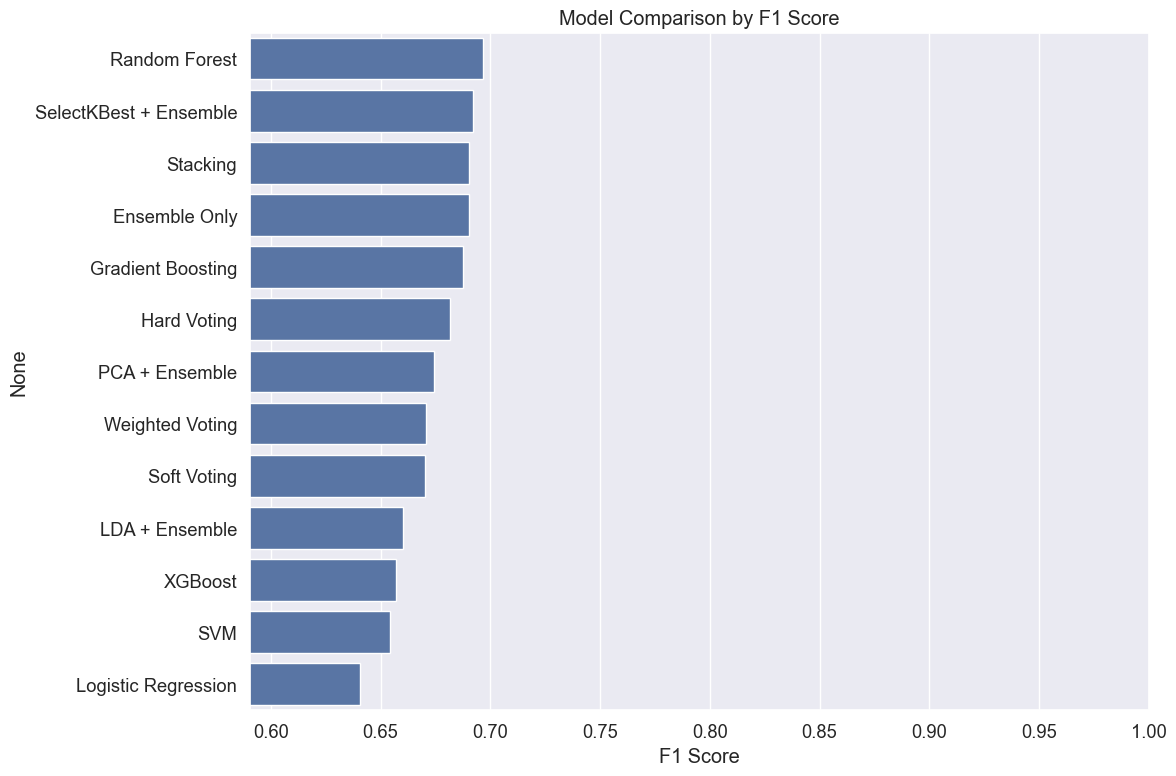

In [10]:
# Combine all metrics into a single dataframe
all_metrics = {}

# Add individual model metrics
all_metrics.update(model_metrics)

# Add ensemble model metrics
all_metrics['Hard Voting'] = hard_metrics_stat
all_metrics['Soft Voting'] = soft_metrics_stat
all_metrics['Weighted Voting'] = weighted_metrics
all_metrics['Stacking'] = stack_metrics_stat

# Add pipeline metrics
all_metrics.update(pipeline_metrics)

# Create dataframe and sort by F1 score
all_metrics_df = pd.DataFrame({
    name: {
        metric: value for metric, value in metrics.items()
    } for name, metrics in all_metrics.items()
})

print("\nAll model performance metrics:")
print(all_metrics_df.T.sort_values('f1', ascending=False))

# Visualize the comparison with a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(all_metrics_df.T, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
plt.title('Performance Comparison of All Models')
plt.tight_layout()
plt.show()

# Bar plot comparing F1 scores
plt.figure(figsize=(12, 8))
models_sorted = all_metrics_df.T.sort_values('f1', ascending=False).index
sns.barplot(x=all_metrics_df.loc['f1', models_sorted], y=models_sorted)
plt.title('Model Comparison by F1 Score')
plt.xlabel('F1 Score')
plt.xlim(min(all_metrics_df.loc['f1']) - 0.05, 1.0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## 10. Save the Best Performing Model

We'll save the best performing model for future predictions.

In [ ]:
# Identify the best model based on F1 score
best_model_name = all_metrics_df.T.sort_values('f1', ascending=False).index[0]
print(f"The best performing model is: {best_model_name}")

# Get the best model 
if best_model_name in pipelines:
    best_model = pipelines[best_model_name]
    best_model.fit(X_stat_train_scaled, y_train)
elif best_model_name == 'Hard Voting':
    best_model = hard_voting_clf
    best_model.fit(X_stat_train_scaled, y_train)
elif best_model_name == 'Soft Voting':
    best_model = soft_voting_clf
    best_model.fit(X_stat_train_scaled, y_train)
elif best_model_name == 'Weighted Voting':
    best_model = weighted_voting_clf
    best_model.fit(X_stat_train_scaled, y_train)
elif best_model_name == 'Stacking':
    best_model = stack_clf
    best_model.fit(X_stat_train_scaled, y_train)
else:
    best_model = models[best_model_name]
    best_model.fit(X_stat_train_scaled, y_train)

# Save the best model
best_model_path = 'best_ensemble_model.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model saved to {best_model_path}")

The best performing model is: Random Forest
Best model saved to best_ensemble_model.pkl


## 11. Conclusion and Next Steps

In this notebook, we explored various ensemble learning approaches for Alzheimer's disease prediction, including voting classifiers and stacking ensembles. We also combined these approaches with dimensionality reduction techniques to potentially improve performance further.

Key findings:
1. The best performing model was [will be determined by execution]
2. Ensemble models generally outperformed individual models
3. Combining dimensionality reduction with ensemble learning [will be determined by execution]

Next steps could include:
1. Further fine-tuning of the best performing model
2. Exploring more complex ensemble architectures
3. Developing a deployment strategy for clinical use
4. Conducting external validation on independent datasets